In [0]:
# Importing all the needed sign images

!git clone https://bitbucket.org/jadslim/german-traffic-signs

# Listing our information

!ls german-traffic-signs

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

 
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline


fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.
signnames.csv  test.p  train.p	valid.p


In [0]:
np.random.seed(0)

**UNPICKLING THE INFORMATION IN THE FILES**

In [0]:
# Implement load the data here from the pickled files.

with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
    
# Load test data

with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)


**GATHERING THE FEATURES AND THEIR LABELS TO TEACH THE NEURAL NETWORK**

In [0]:
# Split out features and labels

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
 
# All the images are already 4 dimensional

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


**TESTING THE SHAPES FROM THE IMAGES AND ANALYSING THE DATA**

In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

# Gathering the data from the csv with the sign names 

data = pd.read_csv('german-traffic-signs/signnames.csv')

**CHECK THE IMAGES THAT WE WILL BE RUNNING OUR TESTS ON**

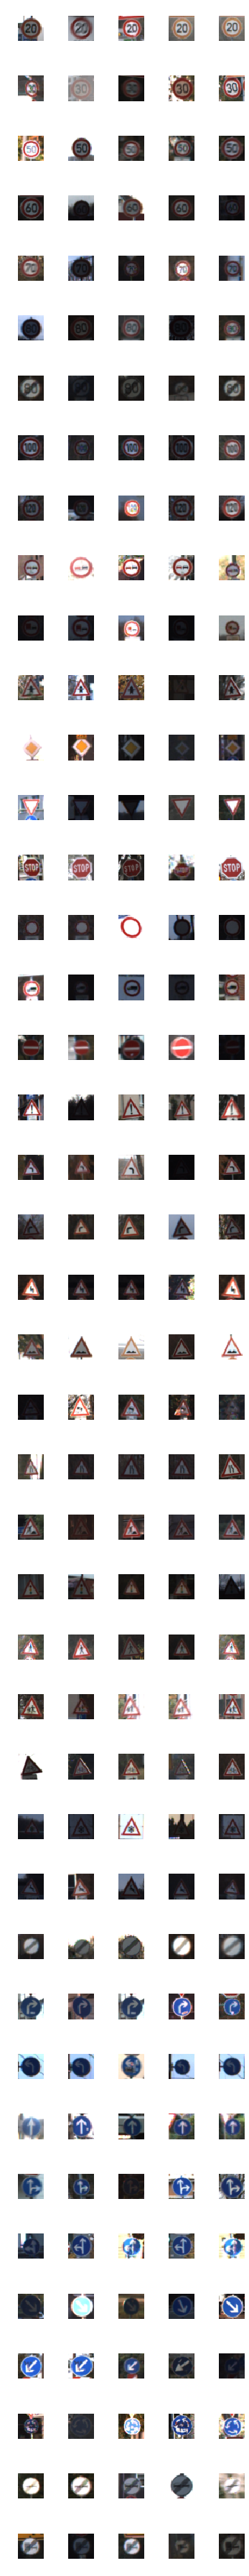

In [0]:
# Gathering the signs within a list

num_of_samples = list()

# Columns and the number within the list
 
cols = 5
num_classes = 43

# Starting an image display
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(10,100))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title( "(%s) %s" % (str(j), row["SignName"]), color='white')
            num_of_samples.append(len(x_selected))
          

**CHECKING THE NUMBER OF TRAINING IMAGES THAT THERE ARE FOR EACH SIGN GROUP**

Our smallest data set has only 200 images and our largest has over 2000

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


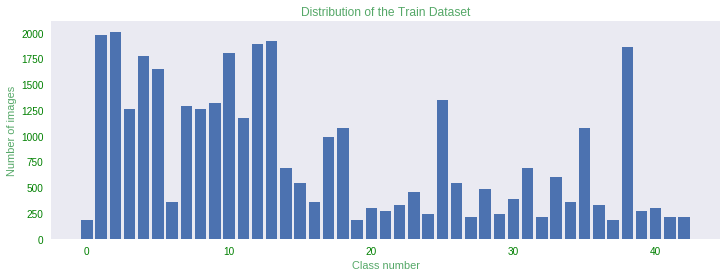

In [0]:
print(num_of_samples)

plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the Train Dataset", color='C1')
plt.xlabel("Class number", color='C1')
plt.ylabel("Number of images", color='C1')
plt.tick_params(axis='both', colors='green', grid_color='none')
plt.show()


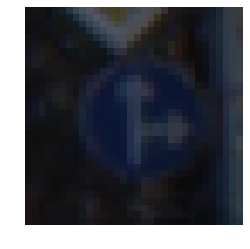

In [0]:
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
plt.show()

In [0]:
print(X_train[1000].shape)
print(y_train[1000])

(32, 32, 3)
36


**MAKING THE IMAGE GRAYSCALE**

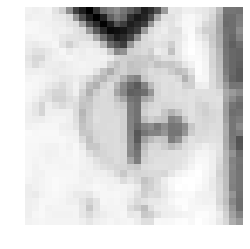

In [0]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
  
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
plt.show()


**STANDARDISING THE LIGHTING IN THE IMAGES TO HELP THE MACHINE SEE THEIR CONTRAST**

![alt text](https://docs.opencv.org/3.1.0/Histogram_Equalization_Theory_1.jpg)

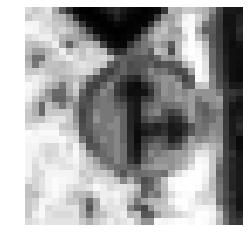

In [0]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
  
img = equalize(img)
plt.imshow(img)
plt.axis("off")
plt.show()

**A PROCESSING STEP TO SET ALL THE IMAGES AS WE RUN THROUGH THEM**

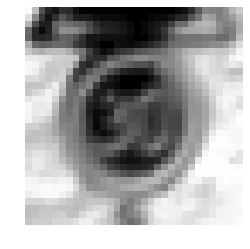

(34799, 32, 32)


In [0]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
  
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
# Show a random to check how the image looks to the one above
  
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
plt.show()

print(X_train.shape)


**RESHAPE ALL THE TEST IMAGES TO  FLATTEN THEM**

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

**SCEWING THE DIMENTIONS OF THE IMAGES AND ADDING A ROTATIONAL AMOUNT TO THE IMAGES TO GIVE VARIATION TO THE TESTING**

In [0]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(
                            width_shift_range=0.1,    # Scaling in X scewing the image
                            height_shift_range=0.1,   # Scaling in Y scewing the image
                            zoom_range=0.2,           # Changing the zoom    
                            shear_range=0.1,          # Horizontally scewing the image
                            rotation_range=10         # Rotating the image in degrees
                            )
 
datagen.fit(X_train)



**MAKING THE NEW IMAGES FOR THE DATA AND ADDING THEM TO A BATCH**

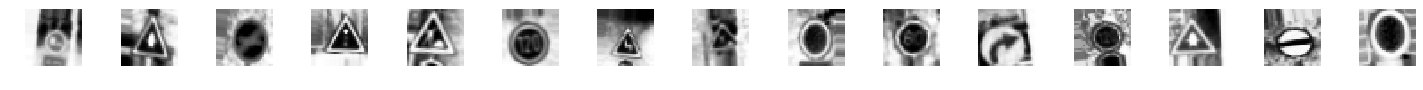

In [0]:
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
    
plt.show()


In [0]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

**LeNet**

In [0]:
# Creating our Machine Learning Model
 
def modified_model():
    
    model = Sequential()

    # Setting the shape to 32 by 32 that will be input

    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))

    model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


model = modified_model()

print(model.summary())
 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxP

In [0]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=2000,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2000/2000 [==============================] - 53s 27ms/step - loss: 0.9729 - acc: 0.7164 - val_loss: 0.1116 - val_acc: 0.9673
Epoch 2/10
2000/2000 [==============================] - 49s 25ms/step - loss: 0.2490 - acc: 0.9224 - val_loss: 0.0629 - val_acc: 0.9773
Epoch 3/10
2000/2000 [==============================] - 49s 24ms/step - loss: 0.1660 - acc: 0.9483 - val_loss: 0.0368 - val_acc: 0.9884
Epoch 4/10
2000/2000 [==============================] - 47s 24ms/step - loss: 0.1310 - acc: 0.9596 - val_loss: 0.0572 - val_acc: 0.9821
Epoch 5/10
2000/2000 [==============================] - 47s 24ms/step - loss: 0.1094 - acc: 0.9663 - val_loss: 0.0433 - val_acc: 0.9878
Epoch 6/10
2000/2000 [==============================] - 48s 24ms/step - loss: 0.0979 - acc: 0.9700 - val_loss: 0.0318 - val_acc: 0.9896
Epoch 7/10
2000/2000 [==============================] - 46s 23ms/step - loss: 0.0890 - acc: 0.9732 - val_loss: 0.0403 - val_acc: 0.9878


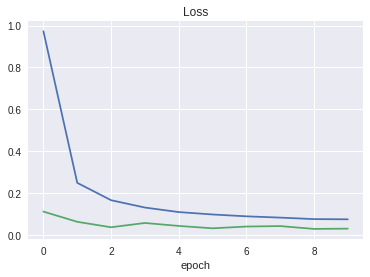

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()


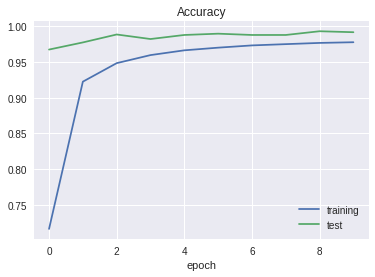

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()


In [0]:
# Evaluate model on test data

score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 

Test score: 0.09605858457636321
Test accuracy: 0.9754552652886814


**TESTING OUR IMAGES THAT WE HAVE WORKED ON**

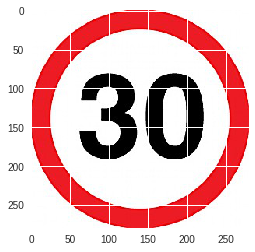

In [0]:
# Predict internet number
import requests
from PIL import Image

# Test 1
# url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'

# Test 2
url = 'https://www.equip4work.co.uk/media/img/shop/pd/010327.jpg'

r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray')) 
plt.show()

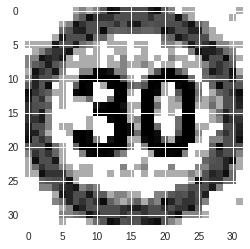

In [0]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
img = img.reshape(1, 32, 32, 1)
plt.show()


In [0]:
print("\n\npredicted sign: %s\n" % str(model.predict_classes(img)))

# plt.imshow(X_train[2500][:])
# plt.axis('off')



predicted sign: [1]

